In [1]:
# Importing the necessary libraries
import pandas as pd
import pickle
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
import scikitplot as skplt
import matplotlib.pyplot as plt

from imblearn.combine import SMOTEENN
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
from xgboost import XGBClassifier


In [3]:
# read training data
# orig 
df = pd.read_csv("C:/Users/hmweti/Desktop/CSV Files/Meds_AnonymisedTrainingData_Delirium.csv")
dataset = loadtxt('C:/Users/hmweti/Desktop/CSV Files/Meds_AnonymisedTrainingData_Delirium.csv', delimiter=",", skiprows=1)

# Obtaining input and target
X = dataset[:, 1:47]
Y = dataset[:, 47]


sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_sample(X, Y)


In [4]:
# split data into train and test sets
seed = 1329
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=test_size, random_state=seed)


In [5]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

C:\Users\hmweti\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Accuracy: 95.39525501873018
Precision: 0.9689696554088805
Recall: 0.9498521107824685
Kappa Score: 0.9062885870495749
F1 Score: 0.954022210048013
Specificity: 0.9594224992153522
NPV: 0.9348186981214505
              precision    recall  f1-score   support

    Delirium       0.93      0.96      0.95     22303
Non-delirium       0.97      0.95      0.96     29752

 avg / total       0.95      0.95      0.95     52055

AUROC: 0.95


C:\Users\hmweti\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning:

Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



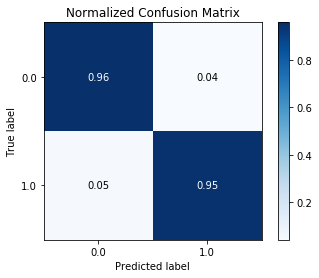

In [12]:
# make predictions for test data
pred_y = model.predict(X_test)
predictions = [round(value) for value in pred_y]

# evaluate prediction metrics
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", (accuracy * 100.0))

print ("Precision:", precision_score(y_test, predictions))

print ("Recall:", recall_score(y_test, predictions))

print("Kappa Score:", cohen_kappa_score(y_test, predictions))

print("F1 Score:", f1_score(y_test, pred_y, average = "weighted"))

tn, fp, fn, tp = confusion_matrix(y_test, pred_y).ravel()

print("Specificity:", tn/(tn+fp))
print("NPV:", tn/(tn+fn))

target_names = ['Delirium', 'Non-delirium']
print(classification_report(y_test, predictions, target_names = target_names))


fpr, tpr, thresholds = roc_curve(y_test, pred_y, pos_label=1)
metrics.auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, pred_y)
print("AUROC: %.2f" % roc_auc)


skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()

In [13]:
# Getting the confidence interval for AUROC
n_bootstraps = 10000
rng_seed = 76  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(pred_y) - 1, len(pred_y))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_test[indices], pred_y[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

In [14]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 95% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.956 - 0.959]


In [10]:
# Validating the model with new data
# id_validation 
df_val = loadtxt('C:/Users/hmweti/Desktop/CSV Files/Meds_AnonymisedValidationData_Delirium.csv', delimiter=",", skiprows=1)

X = df_val[:, 1:47]
Y = df_val[:, 47]

# make predictions for test data
y_predict = model.predict(X)
predictions_1 = [round(value) for value in y_predict]

# evaluate predictions
accuracy = accuracy_score(Y, predictions_1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print ("Precision: %.2f" % precision_score(Y, predictions_1))

print ("Recall: %.2f" % recall_score(Y, predictions_1))


tn, fp, fn, tp = confusion_matrix(Y, predictions_1).ravel()
print("tn:",tn, "fp:", fp, "fn:", fn, "tp:", tp)


print("Specificity:", tn/(tn+fp))
print("NPV:", tn/(tn+fn))


Accuracy: 90.50%
Precision: 0.32
Recall: 0.69
tn: 8076 fp: 729 fn: 154 tp: 337
Specificity: 0.917206132879046
NPV: 0.9812879708383961


C:\Users\hmweti\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



0.8017802558488916


C:\Users\hmweti\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning:

Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



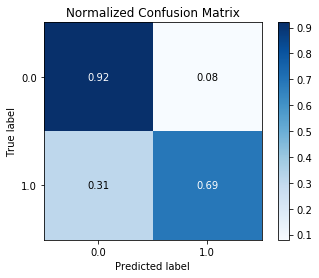

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(Y, y_predict, pos_label=1)
metrics.auc(fpr, tpr)
roc_auc = roc_auc_score(Y, y_predict)
print(roc_auc)

skplt.metrics.plot_confusion_matrix(Y, predictions_1, normalize = True)
plt.show()

In [26]:
import shap

# create our SHAP explainer
shap_explainer = shap.TreeExplainer(model)
# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(X_test)
# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

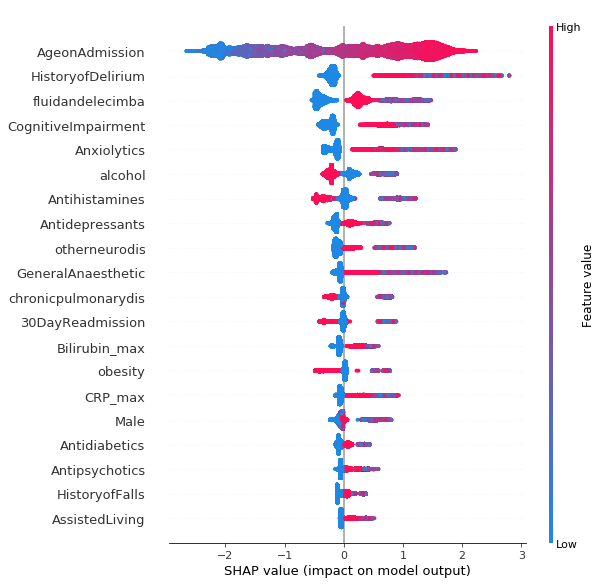

In [30]:
shap.summary_plot(test_shap_vals, X_test, feature_names=cols, auto_size_plot=True)

In [28]:
# remodel using pandas dataset

cols = adjustedcolnames[:46]
targ_col = ["Target"]
Train = pd.DataFrame(X_train,columns=cols)
Test = pd.DataFrame(y_train, columns=targ_col)

# fit model no training data
Estimator = XGBClassifier()
Estimator.fit(Train, Test)

C:\Users\hmweti\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\hmweti\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

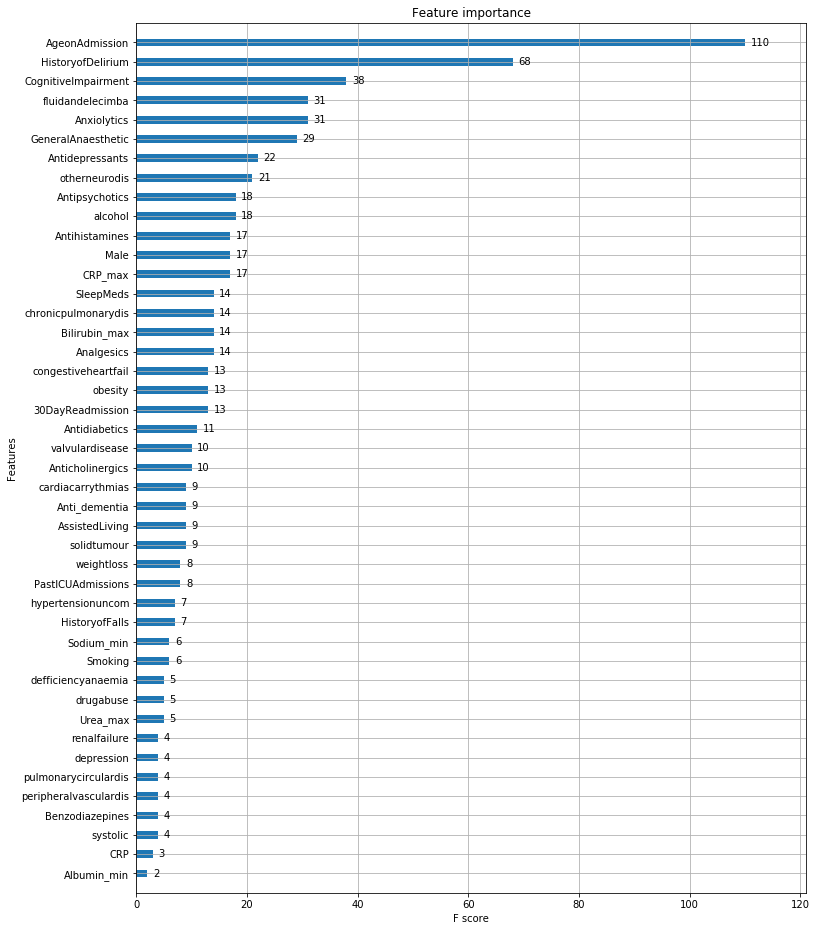

In [29]:
from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = plt.subplots(figsize=(12,16))

plot_importance(Estimator, height=0.4, ax=ax,importance_type = "weight")
pyplot.show()